Import necessary libraries

In [1]:
install.packages("caret")
library(dplyr)
library(ggplot2)
library(caret)
library(class)
library(reshape2)
library(readr)
library(stringr)
library(boot)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice


Attaching package: ‘boot’


The following object is masked from ‘package:lattice’:

    melanoma




Load data. It was already prepared beforehand.

In [2]:
# Install and load the required package if not already installed
if (!requireNamespace("readr", quietly = TRUE)) {
  install.packages("readr")
}
library(readr)

# Define the file paths for all CSV files
file_paths <- c("trips_import_2020-06.csv", "trips_import_2020-05.csv")

# Initialize an empty dataframe
trips <- data.frame()

# Loop through each file, read it, and append to the trips dataframe
for (file_path in file_paths) {
  temp_df <- read_csv(file_path)
  trips <- rbind(trips, temp_df)
}

# View the first few rows of the combined dataframe
head(trips)


Rows: 345277 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): pickup_weekday
dbl (21): trip_distance, RatecodeID, extra, tip_amount, total_amount, pickup...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 208593 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): pickup_weekday
dbl (21): trip_distance, RatecodeID, extra, tip_amount, total_amount, pickup...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


trip_distance,RatecodeID,extra,tip_amount,total_amount,pickuptime_in_seconds,trip_duration,pickup_weekday,PULocationID_encoded,DOLocationID_encoded,⋯,pickup_is_weekend,trip_log_duration,trip_log_distance,trip_duration_squared,trip_distance_squared,duration_log_interaction,duration_distance_squared_interaction,trip_duration_cubed,trip_distance_cubed,duration_distance_cubed_interaction
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.60,1,3.0,4.00,19.3,1883,1115,Monday,15.97617,13.80704,⋯,0,7.017506,1.526056,1243225,12.9600,25.26302,16112196.0,1386195875,46.656000,64674354744
5.60,1,3.0,2.00,23.3,2570,1303,Monday,15.39873,26.66805,⋯,0,7.173192,1.887070,1697809,31.3600,40.16987,53243290.2,2212245127,175.616000,388505640223
2.30,1,0.5,0.00,11.3,2391,558,Monday,13.68903,18.22794,⋯,0,6.326149,1.193922,311364,5.2900,14.55014,1647115.6,173741112,12.167000,2113908110
5.30,1,3.0,0.00,21.3,3373,925,Monday,13.38711,18.22794,⋯,0,6.830874,1.840550,855625,28.0900,36.20363,24034506.2,791453125,148.877000,117829166891
4.40,1,3.0,3.65,18.3,1001,769,Monday,15.24436,13.24517,⋯,0,6.646391,1.686399,591361,19.3600,29.24412,11448749.0,454756609,85.184000,38737986981
1.72,1,0.5,0.00,11.8,389,413,Monday,13.83188,12.93527,⋯,0,6.025866,1.000632,170569,2.9584,10.36449,504611.3,70444997,5.088448,358455704


In [3]:
# Get all column names from the 'trips' dataframe
column_names <- names(trips)

# Print the column names
print(column_names)

 [1] "trip_distance"                        
 [2] "RatecodeID"                           
 [3] "extra"                                
 [4] "tip_amount"                           
 [5] "total_amount"                         
 [6] "pickuptime_in_seconds"                
 [7] "trip_duration"                        
 [8] "pickup_weekday"                       
 [9] "PULocationID_encoded"                 
[10] "DOLocationID_encoded"                 
[11] "VendorID_encoded"                     
[12] "pickup_hour"                          
[13] "pickup_is_weekend"                    
[14] "trip_log_duration"                    
[15] "trip_log_distance"                    
[16] "trip_duration_squared"                
[17] "trip_distance_squared"                
[18] "duration_log_interaction"             
[19] "duration_distance_squared_interaction"
[20] "trip_duration_cubed"                  
[21] "trip_distance_cubed"                  
[22] "duration_distance_cubed_interaction"  


Selection of columns that will be used for knn (continuous and catagorical). Added  transformation - fare per meter.

In [4]:
# Step 1: Select suitable columns and filter them
knn_columns <- c(
  'trip_duration', 'pickuptime_in_seconds',  'pickup_weekday', 'PULocationID_encoded', 'DOLocationID_encoded',
  'VendorID_encoded', 'pickup_is_weekend',  'trip_log_distance'
)

knn_data <- trips[, knn_columns]


Categorize trip duration into 5 categories

In [5]:
# Step 2: categorize trip duration into 5 categories based on quantiles

knn_data$trip_duration_class <- cut(
  knn_data$trip_duration,
  breaks = quantile(knn_data$trip_duration, probs = c(0, 0.2, 0.4, 0.6, 0.8, 1)),
  labels = c(0, 1, 2, 3, 4),
  include.lowest = TRUE
)

print(table(cut(knn_data$trip_duration, breaks = quantile(knn_data$trip_duration, probs = c(0, 0.2, 0.4, 0.6, 0.8, 1)), include.lowest = TRUE)))


       [0,257]      (257,391]      (391,552]      (552,791] (791,1.88e+03] 
        111231         110444         110882         110807         110506 


Filter out strong correlations and constant columns (they don't give anything useful)

In [6]:
numeric_cols <- knn_data[, sapply(knn_data, is.numeric) & names(knn_data) != "trip_duration"]

# Calculate the correlation matrix
corr_matrix <- cor(numeric_cols)
corr_matrix_melt <- melt(corr_matrix) # Melt the correlation matrix

# Remove highly correlated features
high_corr_features <- corr_matrix_melt %>%
  filter(abs(value) > 0.8 & Var1 != Var2)

# Drop the highly correlated features from the original data frame
knn_data_cleaned <- knn_data[, !names(knn_data) %in% high_corr_features$Var1]

In [7]:
high_corr_features

Var1,Var2,value
<fct>,<fct>,<dbl>


Draw correlation matrix

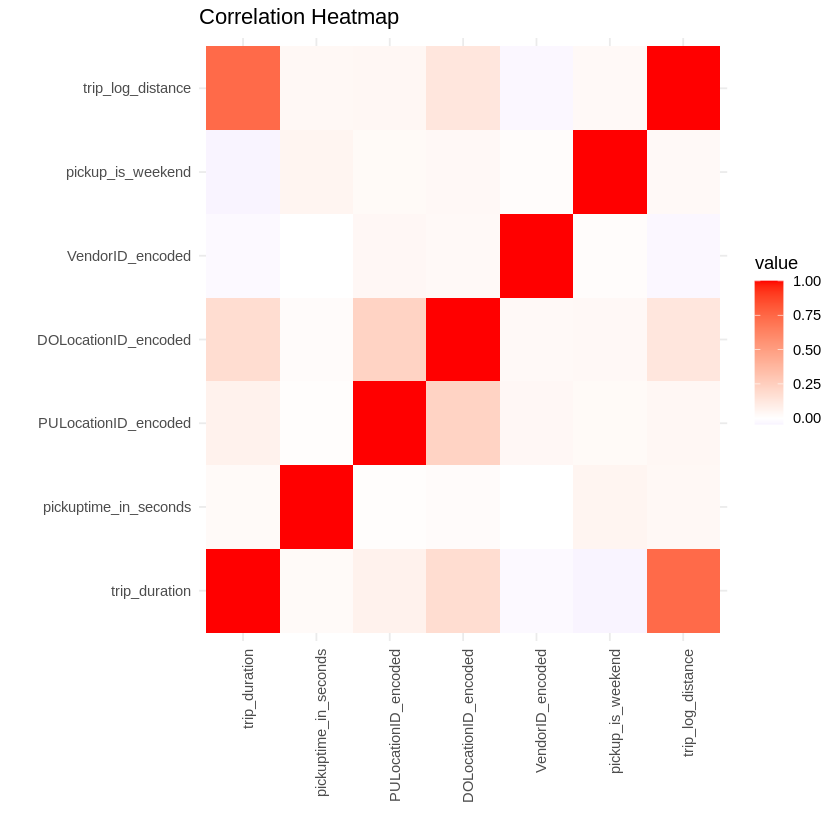

In [8]:
numeric_cols <- knn_data_cleaned[, sapply(knn_data_cleaned, is.numeric)]

corr_matrix <- cor(numeric_cols)

# Plot the heatmap to visualize the correlations
corr_matrix_melt <- melt(corr_matrix)
ggplot(corr_matrix_melt, aes(x = Var1, y = Var2, fill = value)) +
  geom_tile() +
  scale_fill_gradient2(low = "blue", mid = "white", high = "red") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "Correlation Heatmap", x = "", y = "")



Assign dependent and independent variables

In [10]:
# Prepare Features and Target Variable
X <- knn_data_cleaned[, !names(knn_data_cleaned) %in% c("trip_duration", "trip_duration_class")]
y <- knn_data_cleaned$trip_duration_class


Scale

In [11]:
# Scale the features
# Select only numeric columns from the data frame
numeric_columns <- sapply(knn_data_cleaned, is.numeric)  # Identify numeric columns
X_numeric <- knn_data_cleaned[, numeric_columns]         # Subset to only numeric columns

# Scale the numeric features
X_scaled <- scale(X_numeric)  # Scale only the numeric columns

head(X_scaled)


trip_duration,pickuptime_in_seconds,PULocationID_encoded,DOLocationID_encoded,VendorID_encoded,pickup_is_weekend,trip_log_distance
1.7293608,-2.774730,0.03812432,-0.1982507,-0.3916872,-0.507909,1.14726101
2.2939673,-2.734925,-0.05572005,1.6226696,-0.3916872,-0.507909,1.92430538
0.0565637,-2.745296,-0.33357964,0.4276807,-0.3916872,-0.507909,0.43237683
1.1587478,-2.688398,-0.38264727,0.4276807,-0.3916872,-0.507909,1.82417580
0.6902445,-2.825834,-0.08080765,-0.2778031,-0.3916872,-0.507909,1.49238219
-0.3789041,-2.861293,-0.31036316,-0.3216809,-0.2070031,-0.507909,0.01633857


Split the data into training (80%) and testing sets (20% of data)

In [12]:
set.seed(42)
train_index <- sample(nrow(X_scaled), 0.8*nrow(X_scaled))
X_train <- X_scaled[train_index, ]
X_test <- X_scaled[-train_index, ]
y_train <- y[train_index]
y_test <- y[-train_index]

In [13]:
# Load necessary libraries
library(class)  # For KNN
library(parallel)  # For parallel processing

Calculate misclassification error for different k values in order to find optimal k. Find optimal k value by choosing one with lowest misclassifiaction errors. Visualize errors.

In [15]:
# Define the range of k values
k_range <- 1:30  # Try k from 1 to 30

# Define the number of cores
num_cores <- detectCores() - 1  # Use all but one core

# Create a cluster
cl <- makeCluster(num_cores)

# Export necessary objects to the cluster
clusterExport(cl, list("X_train", "X_test", "y_train", "y_test", "knn"))

# Define the function to calculate the error for each k
calculate_error <- function(k) {
  y_pred_k <- knn(train = X_train, test = X_test, cl = y_train, k = k)
  error <- mean(y_pred_k != y_test)  # Calculate misclassification error
  return(error)
}

# Use parLapply to run the function in parallel
error_rate <- parLapply(cl, k_range, calculate_error)

# Convert the result to a vector
error_rate <- unlist(error_rate)

# Stop the cluster after use
stopCluster(cl)

# Check the results
print(error_rate)


 [1] 0.07375377 0.08160760 0.06413960 0.06683879 0.05906621 0.06197303
 [7] 0.05729684 0.05868706 0.05617744 0.05717948 0.05619550 0.05752252
[13] 0.05591565 0.05664687 0.05564483 0.05634896 0.05563580 0.05689061
[19] 0.05543720 0.05626772 0.05596981 0.05589759 0.05596079 0.05666492
[25] 0.05619550 0.05710726 0.05680033 0.05736906 0.05734198 0.05801903


[1] "The optimal k value is: 19"


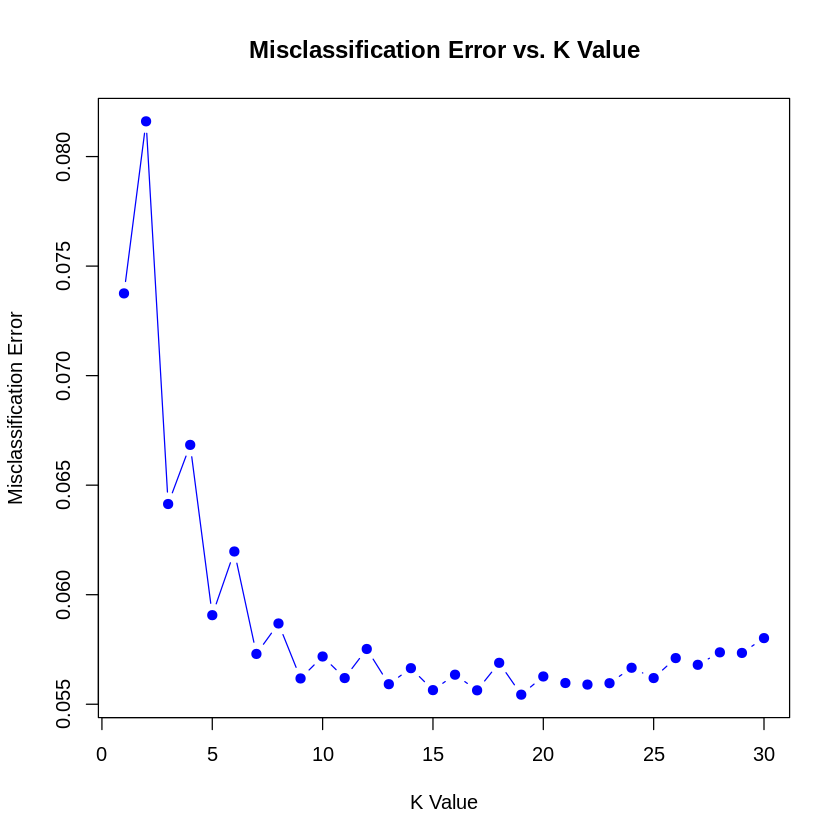

In [16]:
# Find the optimal k value
optimal_k <- k_range[which.min(error_rate)]
print(paste("The optimal k value is:", optimal_k))

# Plot the misclassification error
plot(k_range, error_rate, type = "b", pch = 19, col = "blue",
     main = "Misclassification Error vs. K Value",
     xlab = "K Value", ylab = "Misclassification Error")

Fit KNN with the optimal k

In [17]:
knn <- knn(train = X_train, test = X_train, cl = y_train, k = optimal_k, prob = TRUE)

Confusion Matrix and Statistics

          Reference
Prediction     0     1     2     3     4
         0 21308   789    13     2     0
         1  1014 20403   944     5     4
         2     8   823 20444   800     0
         3     0     8   688 20905   660
         4     0     0     2   386 21568

Overall Statistics
                                          
               Accuracy : 0.9445          
                 95% CI : (0.9432, 0.9459)
    No Information Rate : 0.2016          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.9306          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0 Class: 1 Class: 2 Class: 3 Class: 4
Sensitivity            0.9542   0.9264   0.9254   0.9460   0.9701
Specificity            0.9909   0.9778   0.9816   0.9847   0.9956
Pos Pred Value         0.9636   0.9121   0.9261   0.9391   0.9823
Neg Pre

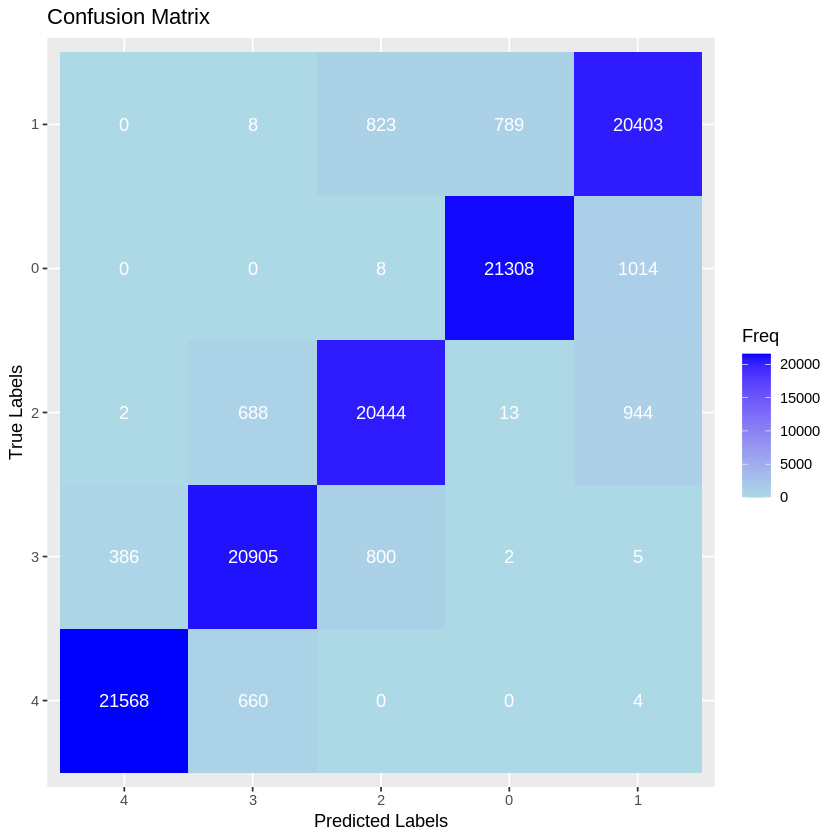

In [18]:
# Predict on the test data
y_pred <- knn(train = X_train, test = X_test, cl = y_train, k = optimal_k)

# Confusion Matrix
conf_matrix <- confusionMatrix(data = y_pred, reference = y_test)

# Display confusion matrix
conf_matrix_df <- as.data.frame(conf_matrix$table)
conf_matrix_df$Prediction <- factor(conf_matrix_df$Prediction, levels = unique(y_test))
conf_matrix_df$Reference <- factor(conf_matrix_df$Reference, levels = unique(y_test))
ggplot(conf_matrix_df, aes(x = Prediction, y = Reference, fill = Freq)) +
  geom_tile() +
  geom_text(aes(label = Freq), color = "white") +
  scale_fill_gradient(low = "lightblue", high = "blue") +
  labs(title = "Confusion Matrix", x = "Predicted Labels", y = "True Labels")

# Classification Report
print(conf_matrix)

- Model is very accurate (0.9445)
-  p-value (< 2.2e-16) indicates that model's accuract is statistically significant
- High sensitivity for all classes (approx 95%) indicates excellent performance for each class

Bootstrap was working for smaller set of data but did not work for this particular dataset.

In [ ]:


knn_boot <- function(data, indices) {
  boot_data <- data[indices, ]

  # Split the bootstrap sample into training and testing sets
  set.seed(123)
  train_idx <- sample(nrow(boot_data), 0.7*nrow(boot_data))
  train_data <- boot_data[train_idx, ]
  test_data <- boot_data[-train_idx, ]

  # Fit the KNN model to the bootstrap training data
  knn_boot <- knn(train = train_data[, -ncol(train_data)], test = test_data[, -ncol(test_data)], cl = train_data[, ncol(train_data)], k = optimal_k, prob = TRUE)

  # Calculate the accuracy
  accuracy_boot <- sum(knn_boot == test_data[, ncol(test_data)]) / nrow(test_data)

  return(accuracy_boot)
}


set.seed(123)
boot_results <- boot(data = cbind(X_train, y_train), statistic = knn_boot, R = 1000)

print("Bootstrap results:")
print(boot_results)

# Calculate the average accuracy
avg_accuracy <- mean(boot_results$t)
print(paste("Average accuracy:", avg_accuracy))

# Calculate the 95% confidence interval
ci <- quantile(boot_results$t, probs = c(0.025, 0.975))
print(paste("95% confidence interval:", ci))